Features

In [1]:
# lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
plt.style.use('tableau-colorblind10')
from pykrx import stock

from features import tautil

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
#코스피
market= stock.get_index_ohlcv("20010101", "20220601", "1001").iloc[:,:-1]
market.columns = ['open','high','low','close','volume']

# 삼성전자 수정거래량
#market.loc[:'2018-4','volume'] *= 50

In [4]:
#fundamentals = stock.get_index_fundamental_by_date("20120101", "20220101","1001").iloc[:,[2,4,5]]
#fundamentals.columns = ['PER','PBR','Dividend Yield']

In [5]:
net_purchase0 = stock.get_market_trading_value_by_date("20010101", "20050101", "KOSPI")
net_purchase1 = stock.get_market_trading_value_by_date("20050101", "20090101", "KOSPI")

In [8]:
net_purchase2 = stock.get_market_trading_value_by_date("20090101", "20130101", "KOSPI")

In [9]:
net_purchase3 = stock.get_market_trading_value_by_date("20130101", "20170101", "KOSPI")
net_purchase4 = stock.get_market_trading_value_by_date("20170101", "20220601", "KOSPI")

In [10]:
net_purchase = pd.concat([net_purchase0,net_purchase1,net_purchase2,net_purchase3,net_purchase4],axis=0).iloc[:,:4]
net_purchase.columns = ['institutions','others_np','individuals','foreigners']
net_purchase.drop(columns=['others_np'],inplace=True)

In [4]:
#df = pd.concat([market,net_purchase],axis=1)
df = market.copy()

In [8]:
df.index = df.index.rename('Date')

import yfinance as yf
oil = yf.download('CL=F', '2001-1-1','2022-6-1')['Adj Close'].rename('crude oil')
gold = yf.download('GC=F','2001-1-1','2022-6-1')['Adj Close'].rename('gold')
gas = yf.download('NG=F','2001-1-1','2022-6-1')['Adj Close'].rename('natural gas')
commodities = pd.concat([oil, gold, gas],axis=1).shift(1).dropna()

import FinanceDataReader as fdr
usd = fdr.DataReader('USD/KRW', '2010-1-1','2022-6-1')['Close'].rename('USD/KRW')
eur = fdr.DataReader('EUR/KRW', '2010-1-1','2022-6-1', data_source='naver')['Close'].rename('EUR/KRW')
jpy = fdr.DataReader('JPY/KRW', '2010-1-1','2022-6-1', data_source='naver')['Close'].rename('JPY/KRW')
cny = fdr.DataReader('CNY/KRW', '2010-1-1','2022-6-1', data_source='naver')['Close'].rename('CNY/KRW')
fx = pd.concat([usd,eur,jpy,cny],axis=1).dropna()

macro = pd.concat([commodities,fx],axis=1).dropna()

df = df.join(macro).dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
df.to_csv("C:data/initial_data.csv")

In [ ]:
df.describe()

In [ ]:
for i in df.columns:
    plt.figure(figsize=(5,5))
    plt.title(i)
    plt.plot(df[i])
    plt.show()

# Feature Generation

## KOSPI MARKET DATA
- 10개의 기술적분석 지표 (1배, 2배)
    - RSI 14
    - Willams's R 14
    - ADX 14          
    - DPO 20
    - MACD (26,12)
    - MACD Difference (26,12,9)
    - ATR 14
    - STD 20
    - FI 13
    - MFI 14 

- 개인, 기관, 외국인 별 순매수량 5일 MA

## MACRO DATA
- 국제유가, 국제 금값, 천연가스, 원달러,  원엔 , 원유로, 위안(달러기준) %change

In [13]:
df_ohlcv = market.copy()
TA = tautil.get_my_ta_windows(df_ohlcv,[1,2]).dropna()

In [14]:
def make_ma_df(df_, window_list):
    df=df_.copy()
    windows_ma=window_list
    for i in df.columns:
        for j in windows_ma:
            df['{} SMA{}'.format(i,j)] = df[i].rolling(j).mean()
            df.dropna(inplace=True)
    out = df.iloc[:,len(df_.T):]
    return out

def make_ret_df(df_):
    df=df_.copy()
    for i in df.columns:
        df['{} %Change'.format(i)] = df[i].pct_change(1)
        df.dropna(inplace=True)
    out = df.iloc[:,len(df_.T):]
    return out

In [15]:
#fundamentals_ma = make_ret_df(fundamentals,[1,5,20])
net_purchase_ma = make_ma_df(net_purchase,[5])
macro_diff = make_ret_df(macro)

NameError: name 'macro' is not defined

In [16]:
features = TA.join([net_purchase_ma, macro_diff]).dropna()
#features = TA.join([macro]).dropna()
features

NameError: name 'macro_diff' is not defined

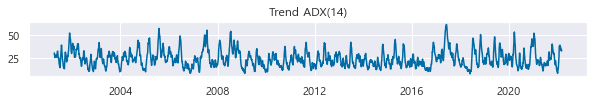

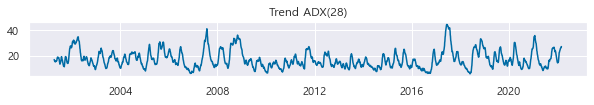

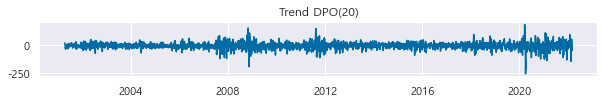

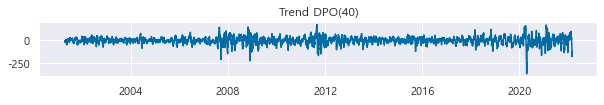

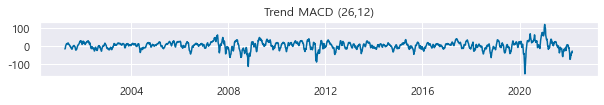

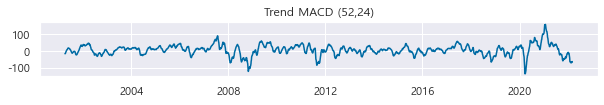

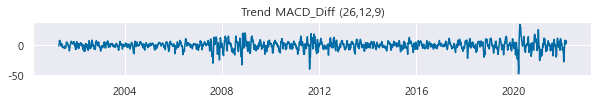

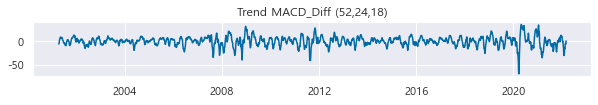

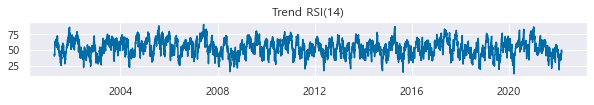

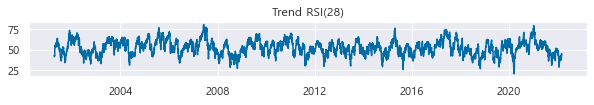

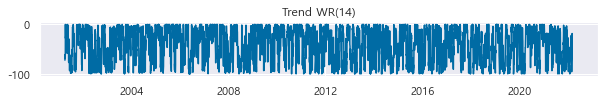

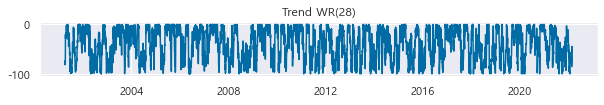

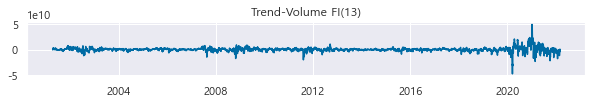

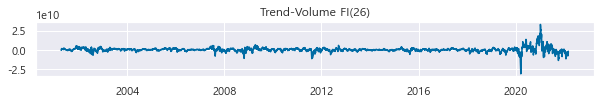

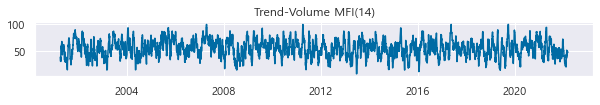

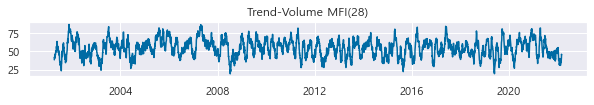

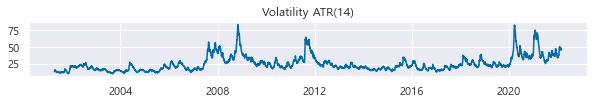

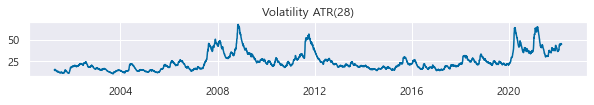

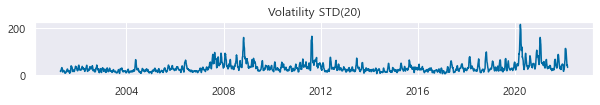

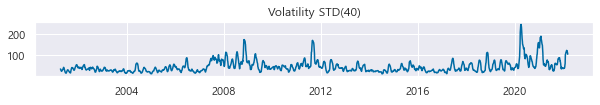

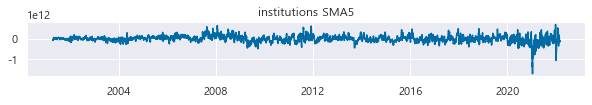

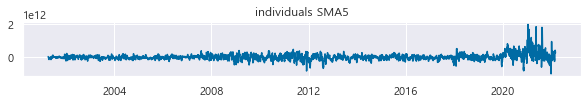

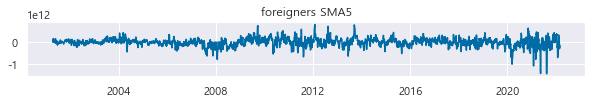

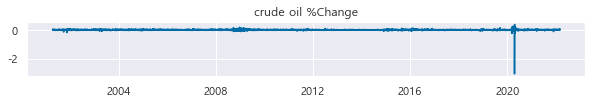

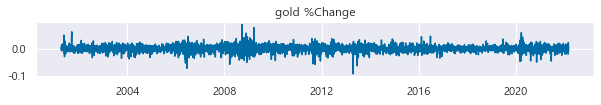

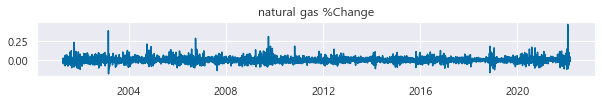

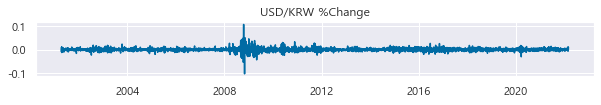

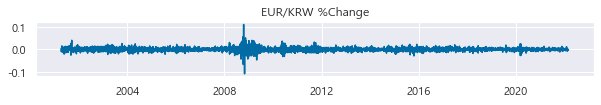

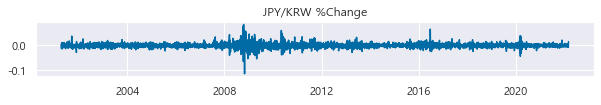

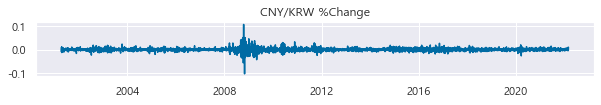

In [35]:
for i in features.columns:
    plt.figure(figsize=(10,1))
    plt.title(i)
    plt.plot(features[i])
    plt.show()

In [36]:
features.to_csv('C:data/features.csv')